In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
from delase.metrics import mase
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import torch
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import get_grid_params_to_use, find_noisy_data, get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import *
from UniversalUnconsciousness.iaaft import surrogates
from UniversalUnconsciousness.plot_utils import *

load_font()
plt.style.use('UniversalUnconsciousness.sci_style')

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'
data_class = 'propofolPuffTone'

In [5]:
# propofol dir
if data_class == 'propofolPuffTone':
    data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class)
    cfg.params.data_class = 'propofolPuffTone'
    cfg.params.grid_set = 'grid_set6'
else:
    data_dir = os.path.join(cfg.params.all_data_dir, data_class, 'mat')
    cfg.params.data_class = 'anesthesiaLvrOdd'
    cfg.params.grid_set = 'grid_set6'


In [6]:
session = "MrJones-Anesthesia-20160123-01"

In [7]:
noise_filter_info = get_noise_filter_info(cfg, [session], force_new=False, verbose=True)

File found for session MrJones-Anesthesia-20160123-01: /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/noise_filter_info/propofolPuffTone/MrJones-Anesthesia-20160123-01__window_15__wakethresh_1__anesthesiathresh_1__electrodenum_1__stride_15.pkl
17 bad electrodes, 727 valid windows (out of 777 total windows)


In [8]:
section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

In [9]:
session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

In [10]:
lfp = TransposedDatasetView(session_file['lfp']).transpose()
dt = session_file['lfpSchema']['smpInterval'][0, 0]
if data_class == 'propofolPuffTone':
    infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
else:
    infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]


In [11]:
wake_t = (infusion_start - 10*60)
anesthesia_t = (infusion_start + 20*60)

In [12]:
wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(wake_t - noise_filter_info[session]['valid_window_starts']))]
anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(anesthesia_t - noise_filter_info[session]['valid_window_starts']))]

wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(noise_filter_info[session]['valid_window_starts'] - wake_window_start))]
anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(noise_filter_info[session]['valid_window_starts'] - anesthesia_window_start))]


In [13]:
bad_electrodes = noise_filter_info[session]['bad_electrodes']
valid_electrodes = [i for i in range(lfp.shape[1]) if i not in bad_electrodes]

In [14]:
window = 15
lfp_w = lfp[int(wake_window_start/dt):int((wake_window_start + window)/dt), valid_electrodes]
lfp_a = lfp[int(anesthesia_window_start/dt):int((anesthesia_window_start + window)/dt), valid_electrodes]

In [21]:
compute_iaaft = True

In [22]:
np.random.seed(42)
n_iaaft = 10
if compute_iaaft:
    lfp_w_iaaft = np.zeros((n_iaaft, lfp_w.shape[0], lfp_w.shape[1]))
    for i in tqdm(range(lfp_w.shape[1])):
        lfp_w_iaaft[..., i] = surrogates(lfp_w[:, i], n_iaaft, verbose=False)

    lfp_a_iaaft = np.zeros((n_iaaft, lfp_a.shape[0], lfp_a.shape[1]))
    for i in tqdm(range(lfp_a.shape[1])):
        lfp_a_iaaft[..., i] = surrogates(lfp_a[:, i], n_iaaft, verbose=False)

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

In [23]:
electrode_areas = convert_h5_string_array(session_file, session_file['electrodeInfo']['area'][0, :])
# delete the bad electrodes
# bad electrodes is a list of electrode indices
good_electrodes = [i for i in range(len(electrode_areas)) if electrode_areas[i] not in bad_electrodes]
electrode_areas = electrode_areas[good_electrodes]

In [24]:
areas = ['all']
# areas = ['vlPFC']
pca_chosen = None
session_list = [session]

if areas[0] == 'all':
    electrodes_to_use = np.arange(lfp_w.shape[1])
else:
    electrodes_to_use = np.where(np.isin(electrode_areas, areas))[0]


In [25]:
cfg.params.stride = 15
grid_params_to_use, grid_search_results = get_grid_params_to_use(cfg, session_list, areas, pca_chosen, log=None, return_results=True, verbose=True)

--------------------
SESSION = MrJones-Anesthesia-20160123-01
--------------------
list exists! loading /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_run_lists/MrJones-Anesthesia-20160123-01_grid_set6_window_15...
Loading data for MrJones-Anesthesia-20160123-01 - all from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_results/MrJones-Anesthesia-20160123-01/NOISE_FILTERED_15_1_1_1_stride_15/NOT_NORMED/SUBSAMPLE_1/[4,0.1]/WINDOW_15/grid_set6/all/NO_PCA


  0%|          | 0/300 [00:00<?, ?it/s]

Results for session: MrJones-Anesthesia-20160123-01, area: all: n_delays=5, rank=1050


In [26]:
n_delays = grid_params_to_use[session][areas[0]]['n_delays']
rank = grid_params_to_use[session][areas[0]]['rank']
n_delays, rank

(5, 1050)

In [27]:
delase_w = DeLASE(lfp_w[:, electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
delase_w.fit()

delase_a = DeLASE(lfp_a[:, electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
delase_a.fit()

if compute_iaaft:

    if lfp_w_iaaft.ndim == 2:
        delase_w_iaaft = DeLASE(lfp_w_iaaft[..., electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
        delase_w_iaaft.fit()

        delase_a_iaaft = DeLASE(lfp_a_iaaft[..., electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
        delase_a_iaaft.fit()
    else:
        delase_w_iaaft = []
        delase_a_iaaft = []
        for i in range(lfp_w_iaaft.shape[0]):
            delase_w_iaaft.append(DeLASE(lfp_w_iaaft[i, ...], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda'))
            delase_w_iaaft[i].fit()
            delase_a_iaaft.append(DeLASE(lfp_a_iaaft[i, ...], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda'))
            delase_a_iaaft[i].fit()


In [28]:
top_percent = 0.1
stab_params_w = delase_w.stability_params.cpu().numpy()[:int(top_percent*len(delase_w.stability_params))]
stab_params_a = delase_a.stability_params.cpu().numpy()[:int(top_percent*len(delase_a.stability_params))]
if compute_iaaft:
    if isinstance(delase_w_iaaft, list):
        stab_params_w_iaaft = np.array([delase_w_iaaft[i].stability_params.cpu().numpy()[:int(top_percent*len(delase_w_iaaft[i].stability_params))] for i in range(len(delase_w_iaaft))])
        stab_params_a_iaaft = np.array([delase_a_iaaft[i].stability_params.cpu().numpy()[:int(top_percent*len(delase_a_iaaft[i].stability_params))] for i in range(len(delase_a_iaaft))])
    else:
        stab_params_w_iaaft = delase_w_iaaft.stability_params.cpu().numpy()[:int(top_percent*len(delase_w_iaaft.stability_params))]
        stab_params_a_iaaft = delase_a_iaaft.stability_params.cpu().numpy()[:int(top_percent*len(delase_a_iaaft.stability_params))]


In [31]:
awake_color = 'limegreen'
anesthesia_color = '#D65CD4'

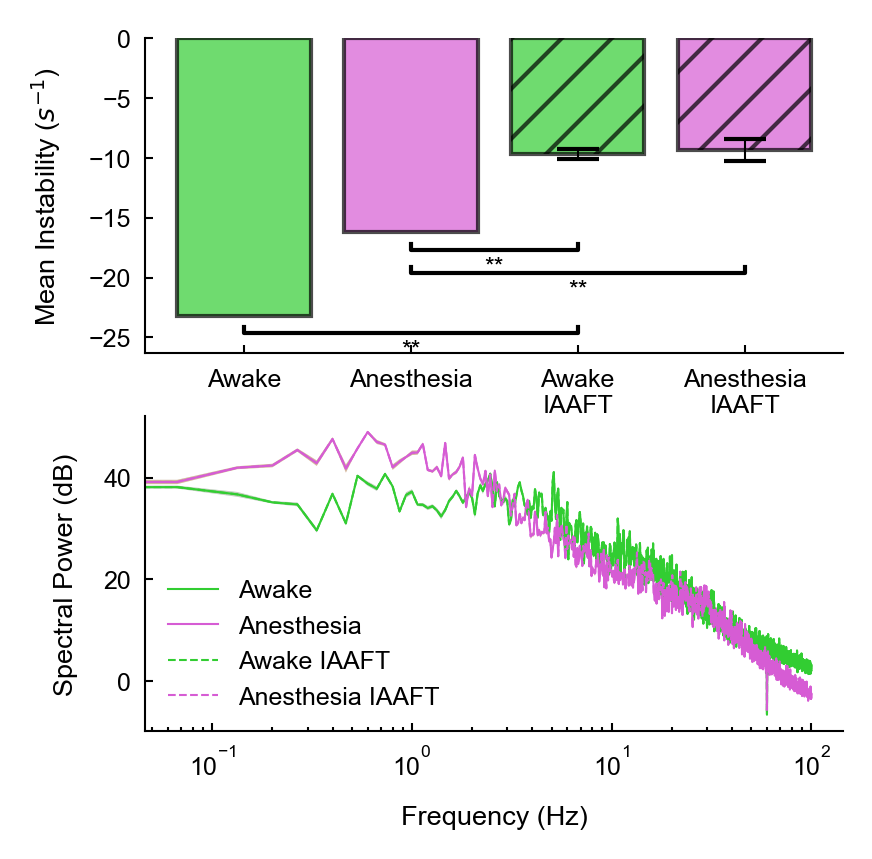

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, sem

fig, axs = plt.subplots(2, 1, figsize=(3, 3))

# Calculate means
ax = axs[0]
mean_stab_wake = stab_params_w.mean()
mean_stab_anesthesia = stab_params_a.mean()
mean_stab_wake_iaaft = stab_params_w_iaaft.mean(axis=1).mean()
mean_stab_anesthesia_iaaft = stab_params_a_iaaft.mean(axis=1).mean()

# Calculate SEMs for IAAFT (SEM across time per surrogate, then mean across surrogates)
sem_stab_wake_iaaft = stab_params_w_iaaft.std(axis=1).mean() / np.sqrt(stab_params_w_iaaft.shape[1])
sem_stab_anesthesia_iaaft = stab_params_a_iaaft.std(axis=1).mean() / np.sqrt(stab_params_a_iaaft.shape[1])

# Prepare data for bar plot
means = [mean_stab_wake, mean_stab_anesthesia, mean_stab_wake_iaaft, mean_stab_anesthesia_iaaft]
sems = [np.nan, np.nan, sem_stab_wake_iaaft, sem_stab_anesthesia_iaaft]  # SEMs only for IAAFT
labels = ['Awake', 'Anesthesia', 'Awake\nIAAFT', 'Anesthesia\nIAAFT']

# Create bar plot
x = np.arange(len(labels))
bars = ax.bar(x, means, yerr=sems, capsize=5, color=['limegreen', '#D65CD4', 'limegreen', '#D65CD4'], alpha=0.7, edgecolor='black')

# Set hatch pattern for IAAFT bars
for i, bar in enumerate(bars):
    if 'IAAFT' in labels[i]:
        bar.set_hatch('//')

# --- Stats: Wilcoxon signed-rank tests (many-to-one vs constant) ---
# Surrogate mean stabilities per IAAFT realization
iaaft_w_means = stab_params_w_iaaft.mean(axis=1)
iaaft_a_means = stab_params_a_iaaft.mean(axis=1)

# Compare against original means (constants)
# Use zero_method='pratt' to handle potential exact zeros cleanly
p_awake_vs_awake_iaaft = wilcoxon(iaaft_w_means - mean_stab_wake, zero_method='pratt').pvalue
p_anesth_vs_anesth_iaaft = wilcoxon(iaaft_a_means - mean_stab_anesthesia, zero_method='pratt').pvalue
p_anesth_vs_awake_iaaft = wilcoxon(iaaft_w_means - mean_stab_anesthesia, zero_method='pratt').pvalue

# Helper to convert p-values to stars
def p_to_stars(p):
    if p < 1e-4:
        return '****'
    if p < 1e-3:
        return '***'
    if p < 1e-2:
        return '**'
    if p < 5e-2:
        return '*'
    return 'n.s.'

# Helper to compute top/bottom of a bar including error if present
def bar_top(i):
    height = bars[i].get_height()
    err = 0.0 if (i >= len(sems) or np.isnan(sems[i])) else float(sems[i])
    return height + err

def bar_bottom(i):
    height = bars[i].get_height()
    err = 0.0 if (i >= len(sems) or np.isnan(sems[i])) else float(sems[i])
    return height - err

# Draw significance brackets UNDER the bars on the left plot
range_y = ax.get_ylim()[1] - ax.get_ylim()[0]
range_y = range_y if range_y > 0 else 1.0
base_offset = 0.04 * range_y  # offset from the bars

comparisons = [
    (0, 2, p_awake_vs_awake_iaaft),       # Awake vs Awake IAAFT
    (1, 3, p_anesth_vs_anesth_iaaft),     # Anesthesia vs Anesthesia IAAFT
    (1, 2, p_anesth_vs_awake_iaaft),      # Anesthesia vs Awake IAAFT
]

# Order from closest to bars (top) to farthest (bottom): higher bottoms first
comparisons_sorted = sorted(
    comparisons,
    key=lambda c: (min(bar_bottom(c[0]), bar_bottom(c[1])), -abs(c[0]-c[1])),
    reverse=True,
)

gap = 0.08 * range_y   # minimum vertical gap between successive brackets
text_margin = 0.02 * range_y
h = 0.02 * range_y
prev_y = None
new_bottom_needed = ax.get_ylim()[0]

for (i, j, p) in comparisons_sorted:
    # nominal position just under the lower of the two bars
    y_nominal = min(bar_bottom(i), bar_bottom(j)) - base_offset
    if prev_y is None:
        y = y_nominal
    else:
        # ensure the next bracket is at least `gap` below the previous one
        y = min(y_nominal, prev_y - gap)
    x1, x2 = i, j
    # Draw bracket below (opening downward)
    ax.plot([x1, x1, x2, x2], [y, y - h, y - h, y], color='black', linewidth=1)
    star_y = y - h - text_margin
    ax.text((x1 + x2) / 2, star_y, p_to_stars(p), ha='center', va='top', color='black')
    new_bottom_needed = min(new_bottom_needed, star_y - 0.05 * range_y)
    prev_y = y

# If needed, expand y-limit downward to fit brackets
ylim_low, ylim_high = ax.get_ylim()
if new_bottom_needed < ylim_low:
    ax.set_ylim(new_bottom_needed, ylim_high)

ax.set_xticks(x, labels)
ax.set_ylabel('Mean Instability ($s^{-1}$)')
# ax.set_title(f'Stability Across ({n_iaaft} Surrogates)')

# --- Right subplot: FFTs ---
ax = axs[1]

fft_lfp_w = np.fft.rfft(lfp_w, axis=0)
fft_lfp_a = np.fft.rfft(lfp_a, axis=0)
fft_lfp_w_iaaft = np.fft.rfft(lfp_w_iaaft, axis=1)
fft_lfp_a_iaaft = np.fft.rfft(lfp_a_iaaft, axis=1)
freqs = np.fft.rfftfreq(lfp_w.shape[0], d=dt)

min_freq = 0
max_freq = 100
freq_inds = (freqs >= min_freq) & (freqs <= max_freq)

# Calculate means and SEMs
fft_lfp_w_db = 20*np.log10(np.abs(fft_lfp_w))
fft_lfp_a_db = 20*np.log10(np.abs(fft_lfp_a))
fft_lfp_w_iaaft_db = 20*np.log10(np.abs(fft_lfp_w_iaaft))
fft_lfp_a_iaaft_db = 20*np.log10(np.abs(fft_lfp_a_iaaft))

mean_wake = fft_lfp_w_db.mean(axis=-1)[freq_inds]
sem_wake = sem(fft_lfp_w_db, axis=-1)[freq_inds]

mean_anesthesia = fft_lfp_a_db.mean(axis=-1)[freq_inds]
sem_anesthesia = sem(fft_lfp_a_db, axis=-1)[freq_inds]

mean_wake_iaaft = fft_lfp_w_iaaft_db.mean(axis=-1)[:, freq_inds].mean(axis=0)
sem_wake_iaaft = sem(fft_lfp_w_iaaft_db, axis=-1)[:, freq_inds].mean(axis=0)

mean_anesthesia_iaaft = fft_lfp_a_iaaft_db.mean(axis=-1)[:, freq_inds].mean(axis=0)
sem_anesthesia_iaaft = sem(fft_lfp_a_iaaft_db, axis=-1)[:, freq_inds].mean(axis=0)

# Plot with fill_between for SEM
ax.plot(freqs[freq_inds], mean_wake, label='Awake', color='limegreen')
ax.fill_between(freqs[freq_inds], mean_wake - sem_wake, mean_wake + sem_wake, alpha=0.3)

ax.plot(freqs[freq_inds], mean_anesthesia, label='Anesthesia', color='#D65CD4')
ax.fill_between(freqs[freq_inds], mean_anesthesia - sem_anesthesia, mean_anesthesia + sem_anesthesia, alpha=0.3)

ax.plot(freqs[freq_inds], mean_wake_iaaft, label='Awake IAAFT', color='limegreen', linestyle='--')
ax.fill_between(freqs[freq_inds], mean_wake_iaaft - sem_wake_iaaft, mean_wake_iaaft + sem_wake_iaaft, alpha=0.3)

ax.plot(freqs[freq_inds], mean_anesthesia_iaaft, label='Anesthesia IAAFT', color='#D65CD4', linestyle='--')
ax.fill_between(freqs[freq_inds], mean_anesthesia_iaaft - sem_anesthesia_iaaft, mean_anesthesia_iaaft + sem_anesthesia_iaaft, alpha=0.3)
# plt.yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral Power (dB)')
# ax.set_title(f'FFT ({n_iaaft} Surrogates)')
plt.savefig(os.path.join(cfg.plotting.img_save_dir, 'supp', f'IAAFT_surrogate_comparison.pdf'), transparent=True, bbox_inches='tight')
plt.show()